In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
import random

In [23]:
# # Reading the input data
# import pandas as pd 
# num_records = 40428967
# sample_size = 5000000
# skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
# parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

# train = pd.read_csv("train.csv", parse_dates=['hour'], date_parser=parse_date,\
#                      skiprows=skip_values)

In [24]:
# train.to_csv('train_cut.csv',Index)

In [2]:
# Tạo một phiên Spark mới
spark = SparkSession.builder.appName("CTR Prediction").getOrCreate()

In [3]:
# num_records = 40428967
# sample_size = 10
# skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
schema = StructType([
    StructField("index", StringType(), True),
    StructField("id", StringType(), True),
    StructField("click", IntegerType(), True),
    StructField("hour", StringType(), True),
    StructField("C1", IntegerType(), True),
    StructField("banner_pos", IntegerType(), True),
    StructField("site_id", StringType(), True),
    StructField("site_domain", StringType(), True),
    StructField("site_category", StringType(), True),
    StructField("app_id", StringType(), True),
    StructField("app_domain", StringType(), True),
    StructField("app_category", StringType(), True),
    StructField("device_id", StringType(), True),
    StructField("device_ip", StringType(), True),
    StructField("device_model", StringType(), True),
    StructField("device_type", IntegerType(), True),
    StructField("device_conn_type", IntegerType(), True),
    StructField("C14", IntegerType(), True),
    StructField("C15", IntegerType(), True),
    StructField("C16", IntegerType(), True),
    StructField("C17", IntegerType(), True),
    StructField("C18", IntegerType(), True),
    StructField("C19", IntegerType(), True),
    StructField("C20", IntegerType(), True),
    StructField("C21", IntegerType(), True)
])

train = spark.read.csv(
    "train_cut.csv",
    header=True,
    schema=schema,
    timestampFormat="yyMMddHH",
    nullValue="")
    # mode="DROPMALFORMED")
# ).filter(~col("index").isin(skip_values))

In [27]:
schema = StructType([
    StructField("id", StringType(), True),
    StructField("hour", StringType(), True),
    StructField("C1", IntegerType(), True),
    StructField("banner_pos", IntegerType(), True),
    StructField("site_id", StringType(), True),
    StructField("site_domain", StringType(), True),
    StructField("site_category", StringType(), True),
    StructField("app_id", StringType(), True),
    StructField("app_domain", StringType(), True),
    StructField("app_category", StringType(), True),
    StructField("device_id", StringType(), True),
    StructField("device_ip", StringType(), True),
    StructField("device_model", StringType(), True),
    StructField("device_type", IntegerType(), True),
    StructField("device_conn_type", IntegerType(), True),
    StructField("C14", IntegerType(), True),
    StructField("C15", IntegerType(), True),
    StructField("C16", IntegerType(), True),
    StructField("C17", IntegerType(), True),
    StructField("C18", IntegerType(), True),
    StructField("C19", IntegerType(), True),
    StructField("C20", IntegerType(), True),
    StructField("C21", IntegerType(), True)
])

# test= spark.read.format("csv").option("header", "true").load("test.csv")
test = spark.read.csv(
    "test.csv",
    header=True,
    schema=schema,
    # timestampFormat="yyMMddHH",
    nullValue="",
    # mode="DROPMALFORMED"
)

In [28]:
# # # Đọc dữ liệu từ tập tin CSV và tạo một DataFrame
# # train = spark.read.format("csv").option("header", "true").load("train_cut.csv")

# test_1= spark.read.format("csv").option("header", "true").load("test.csv")

In [29]:
test.show()

+--------------------+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+
|                  id|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18| C19|   C20|C21|
+--------------------+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+
|10000174058809263569|14103100|1005|         0|235ba823|   f6ebf28e|     f028772b|ecad2386|  7801e8d9|    07d7df22| a99f214a| 69f45779|    0eb711ec|          1|               0| 8330|320| 50| 761|  3| 175|100075| 23|
|10000182526920855428|14103100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| e8d446

# Data preperation

In [4]:
# tách cột hour ra 4 cột mới
from pyspark.sql.functions import month, dayofweek, dayofmonth, hour

train = train.withColumn("month", month("hour"))
train = train.withColumn("dayofweek", dayofweek("hour"))
train = train.withColumn("day", dayofmonth("hour"))
train = train.withColumn("hour_time", hour("hour"))
train.show(5)

+-----+--------------------+-----+----------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+-----+---------+---+---------+
|index|                  id|click|      hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|month|dayofweek|day|hour_time|
+-----+--------------------+-----+----------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+-----+---------+---+---------+
|    0| 1000009418151094273|    0|2014-10-21|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| ddd2926e|    44956a24|          1|               2|15706|320| 50|1722|  0| 35|  

In [6]:
type(train)

pyspark.sql.dataframe.DataFrame

In [8]:
train.approxQuantile('C15', [0.98], 0.25)

[1024.0]

In [9]:
print(dir(train))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_collect_as_arrow', '_jcols', '_jdf', '_jmap', '_jseq', '_lazy_rdd', '_repr_html_', '_sc', '_schema', '_sort_cols', '_support_repr_html', '_to_corrected_pandas_type', 'agg', 'alias', 'approxQuantile', 'cache', 'checkpoint', 'coalesce', 'colRegex', 'collect', 'columns', 'corr', 'count', 'cov', 'createGlobalTempView', 'createOrReplaceGlobalTempView', 'createOrReplaceTempView', 'createTempView', 'crossJoin', 'crosstab', 'cube', 'describe', 'distinct', 'drop', 'dropDuplicates', 'drop_duplicates', 'dropna', 'dtypes', 'exceptAll', 'explain', 'fillna', 'filter', 'first', 'foreach', 'foreachPartition', 'freqItems', 'groupBy'

In [5]:
# dealing with outliers by capping
from pyspark.sql.functions import col, when

cols = ['C15', 'C16', 'C19', 'C21']
for col_name in cols:
    quantile_val = train.approxQuantile(col_name, [0.98], 0.25)[0]
    if quantile_val < 0.5 * train.select(col_name).rdd.max()[0]:
        train = train.withColumn(col_name, when(col(col_name) >= quantile_val, quantile_val).otherwise(col(col_name)))

train.show(5)

+-----+--------------------+-----+----------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+-----+---------+---+---------+
|index|                  id|click|      hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|month|dayofweek|day|hour_time|
+-----+--------------------+-----+----------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+-----+---------+---+---------+
|    0| 1000009418151094273|    0|2014-10-21|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| ddd2926e|    44956a24|          1|               2|15706|320| 50|1722|  0| 35|  

In [32]:
# id column have a unique columns so, keeping that don't proive any significance,hence dropping.
# hour column have been derived into different columns, hence dropping. 
# rename click to y (output)
# after dropping hour column, hour_time can be made as hour

from pyspark.sql.functions import col

train = train.drop("id").drop("hour").drop("index")
train = train.withColumnRenamed("click", "y").withColumnRenamed("hour_time", "hour")
train.show(5)

+---+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+-----+---------+---+----+
|  y|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|month|dayofweek|day|hour|
+---+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+-----+---------+---+----+
|  0|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| ddd2926e|    44956a24|          1|               2|15706|320| 50|1722|  0| 35|    -1| 79|   10|        3| 21|   0|
|  0|1005|         1|e151e245|   7e091613|     f028772b|ecad2386|  7801e8d9|    07d7df22| a99f214a| 5d877109|    8f5c9827|          1|      

# test logistic regression
-> chia giữ liệu train test -> tạo pipeline

In [62]:
# # function
# from pyspark.sql import functions as F
# def target_mean_encoding(df, col, target):
#     """
#     :param df: pyspark.sql.dataframe
#         dataframe to apply target mean encoding
#     :param col: str list
#         list of columns to apply target encoding
#     :param target: str
#         target column
#     :return:
#         dataframe with target encoded columns
#     """
#     target_encoded_columns_list = []
#     for c in col:
#         print(c)
#         means = df.groupby(F.col(c)).agg(F.mean(target).alias(f"{c}_mean_encoding"))
#         dict_ = means.toPandas().to_dict()
#         target_encoded_columns = [F.when(F.col(c) == v, encoder)
#                                   for v, encoder in zip(dict_[c].values(),
#                                                         dict_[f"{c}_mean_encoding"].values())]
#         target_encoded_columns_list.append(F.coalesce(*target_encoded_columns).alias(f"{c}_mean_encoding"))
#     return df.select(target, *target_encoded_columns_list)


In [63]:
# # chọn thuộc tính + encode, bỏ 'device_id'
# #'site_id','site_domain','site_category','app_id','app_domain','app_category','device_id','device_ip','device_model'
# df_target_encoded = target_mean_encoding(train_test_1, col=['site_id','site_domain','site_category','app_id','app_domain','app_category','device_model'],
#                                           target='y')

site_id


site_domain
site_category
app_id
app_domain
app_category
device_model


In [73]:
sampled_data = train.sample(fraction=0.1, seed=42)
X = sampled_data.drop("y")
y = sampled_data.select("y")

+---+-------+--------+
|  y|  count|   ratio|
+---+-------+--------+
|  1| 848930|0.169786|
|  0|4151070|0.830214|
+---+-------+--------+



<Figure size 640x480 with 0 Axes>

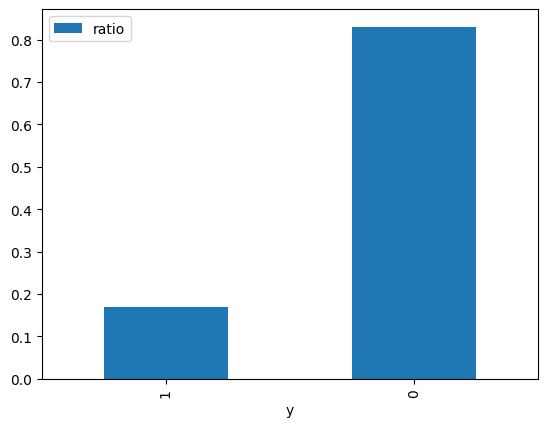

In [74]:
import matplotlib.pyplot as plt

output_dist = train.groupBy("y").count().withColumn("ratio", col("count") / train.count())
output_dist.show()
plt.figure()
output_dist.toPandas().plot(kind="bar", x="y", y="ratio")
plt.show()

In [85]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 70:30
(trainingData, testData) = train.randomSplit([0.7, 0.3], seed=1234)

In [81]:
# tạo pipeline luôn

In [76]:
from pyspark.ml.feature import StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in list(x for x in set(train.columns) if x in {'site_id','site_domain','site_category','app_id','app_domain','app_category','device_id','device_ip','device_model'})]

In [88]:
list_features = ['site_domain_index','site_id_index','app_category_index','app_domain_index','site_category_index','C16','C21','app_id_index','C18','device_type','banner_pos','device_model_index','device_conn_type','C17','device_id_index','C19']
assembler = VectorAssembler(inputCols=[col for col in list_features], outputCol="features")

In [89]:
lr = LogisticRegression(labelCol="y", featuresCol="features")

In [90]:
pipeline = Pipeline(stages=indexers +[assembler, lr])

In [ ]:
# Load your data into a PySpark dataframe
df = spark.read.csv("your_data.csv", header=True, inferSchema=True)

# Randomly sample 5000 rows from the dataframe
df_sample = df.sample(withReplacement=False, fraction=5000/df.count(), seed=123)

# Show the first 10 rows of the sampled dataframe
df_sample.show(10)

In [94]:
train

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:54678)
Traceback (most recent call last):
  File "C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\py4j\java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\py4j\java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:54678)

DataFrame[y: int, C1: int, banner_pos: int, site_id: string, site_domain: string, site_category: string, app_id: string, app_domain: string, app_category: string, device_id: string, device_ip: string, device_model: string, device_type: int, device_conn_type: int, C14: int, C15: int, C16: int, C17: int, C18: int, C19: int, C20: int, C21: int, month: int, dayofweek: int, day: int, hour: int]

In [93]:
sampled_data = trainingData.sample(withReplacement=False, fraction=5000/trainingData.count(), seed=123)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:54678)
Traceback (most recent call last):
  File "C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\py4j\java_gateway.py", line 1193, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\py4j\java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\py4j\java_gateway.py", line 1196, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:54678)

In [91]:
# Huấn luyện pipeline trên tập huấn luyện
model = pipeline.fit(trainingData)

Py4JJavaError: An error occurred while calling o4901925.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 183.0 failed 1 times, most recent failure: Lost task 0.0 in stage 183.0 (TID 9078, DESKTOP-G3D99FP, executor driver): java.lang.OutOfMemoryError: Java heap space

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2194)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1157)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1151)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1220)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1196)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:499)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:487)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:482)
	at org.apache.spark.ml.classification.LogisticRegression.train(LogisticRegression.scala:281)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:150)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.lang.OutOfMemoryError: Java heap space


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 54796)
Traceback (most recent call last):
  File "c:\Program Files\Python39\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\Program Files\Python39\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "c:\Program Files\Python39\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\Program Files\Python39\lib\socketserver.py", line 747, in __init__
    self.handle()
  File "C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\pyspark\accumulators.py", line 268, in handle
    poll(accum_updates)
  File "C:\Users\marti\AppData\Roaming\Python\Python39\site-packages\pyspark\accumulators.py", line 241, in poll
    if func():
  File "C:\Users\marti\AppData\Roaming\Python\Python39\site-packag